In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

zip_ref=zipfile.ZipFile('/content/drive/MyDrive/congestion.zip','r')
zip_ref.extractall('/content/congestion')
zip_ref.close()

os.listdir('/content/congestion')

['congestion']

In [3]:
import shutil
from sklearn.model_selection import train_test_split

heavy_dir='/content/congestion/congestion/heavy'
light_dir='/content/congestion/congestion/light'

base_dir='/content/congestion_split'
train_dir=os.path.join(base_dir,'train')
val_dir=os.path.join(base_dir,'val')
test_dir=os.path.join(base_dir,'test')

for dir_path in [train_dir,val_dir,test_dir]:
  os.makedirs(os.path.join(dir_path,'heavy'),exist_ok=True)
  os.makedirs(os.path.join(dir_path,'light'),exist_ok=True)

def split_copy(file_list,output_dir,category):
  for file in file_list:
    src=os.path.join(heavy_dir if category=='heavy' else light_dir,file)
    dest=os.path.join(output_dir,category,file)
    shutil.copyfile(src,dest)

heavy_img=sorted([f for f in os.listdir(heavy_dir) if f.startswith('heavy')])
light_img=sorted([f for f in os.listdir(light_dir) if f.startswith('light')])

heavy_train, heavy_temp=train_test_split(heavy_img,test_size=0.3,random_state=42)
heavy_val,heavy_test=train_test_split(heavy_img,test_size=0.5,random_state=42)

light_train,light_temp=train_test_split(light_img,test_size=0.3,random_state=42)
light_val,light_test=train_test_split(light_img,test_size=0.5,random_state=42)

split_copy(heavy_train,train_dir,'heavy')
split_copy(heavy_val,val_dir,'heavy')
split_copy(heavy_test,test_dir,'heavy')

split_copy(light_train,train_dir,'light')
split_copy(light_val,val_dir,'light')
split_copy(light_test,test_dir,'light')

In [4]:
print("Training set-Heavy Traffic:",len(os.listdir(os.path.join(train_dir,'heavy'))))
print("Training set-Light Traffic:",len(os.listdir(os.path.join(train_dir,'light'))))

print("Validation set-Heavy Traffic:",len(os.listdir(os.path.join(val_dir,'heavy'))))
print("Validation set-Light Traffic:",len(os.listdir(os.path.join(val_dir,'light'))))

print("Test set-Heavy Traffic:",len(os.listdir(os.path.join(test_dir,'heavy'))))
print("Test set-Light Traffic:",len(os.listdir(os.path.join(test_dir,'light'))))

Training set-Heavy Traffic: 2795
Training set-Light Traffic: 2131
Validation set-Heavy Traffic: 1996
Validation set-Light Traffic: 1522
Test set-Heavy Traffic: 1997
Test set-Light Traffic: 1523


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [6]:
train_gen=ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
val_gen=ImageDataGenerator(rescale=1./255)

train_generator=train_gen.flow_from_directory(train_dir,target_size=(150,150),batch_size=32,class_mode='binary')
val_generator=val_gen.flow_from_directory(val_dir,target_size=(150,150),batch_size=32,class_mode='binary')
test_generator=val_gen.flow_from_directory(test_dir,target_size=(150,150),batch_size=32,class_mode='binary')

Found 4926 images belonging to 2 classes.
Found 3518 images belonging to 2 classes.
Found 3520 images belonging to 2 classes.


In [7]:
model=Sequential([Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),MaxPooling2D(2,2),
                  Conv2D(64,(3,3),activation='relu'),MaxPooling2D(2,2),
                  Conv2D(128,(3,3),activation='relu'),MaxPooling2D(2,2),
                  Flatten(),
                  Dense(512,activation='relu'),
                  Dropout(0.5),
                  Dense(1,activation='sigmoid')])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.6358 - loss: 0.6551 - val_accuracy: 0.8243 - val_loss: 0.4022
Epoch 2/10
  1/153 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8438 - loss: 0.3513

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8438 - loss: 0.3513 - val_accuracy: 0.8000 - val_loss: 0.4707
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 72s 251ms/step - accuracy: 0.7965 - loss: 0.4530 - val_accuracy: 0.8538 - val_loss: 0.3331
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7812 - loss: 0.3473 - val_accuracy: 0.8333 - val_loss: 0.3247
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 74s 238ms/step - accuracy: 0.8449 - loss: 0.3755 - val_accuracy: 0.7893 - val_loss: 0.4600
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - accuracy: 0.7812 - loss: 0.4334 - val_accuracy: 0.9333 - val_loss: 0.2529
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.8540 - loss: 0.3342 - val_accuracy: 0.9200 - val_loss: 0.1970
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.8438 - loss: 0.3320 - val_accuracy: 0.9000 - val_loss: 0.1758
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.8755 - loss: 0.2948 - val_accura

In [9]:
test_loss,test_acc=model.evaluate(test_generator,steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')

y_pred = model.predict(test_generator)
y_pred_classes = [1 if pred > 0.5 else 0 for pred in y_pred]

110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9167 - loss: 0.1913
Test accuracy: 0.92
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step


In [10]:
model.save('traffic_congestion_cnn.h5')

In [11]:
from tensorflow.keras.models import load_model

model=load_model("traffic_congestion_cnn.h5")

In [12]:
import random
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,img_to_array

test_dir='/content/congestion_split/test'

image_files = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_files.append(os.path.join(root, file))

#test_images=os.listdir(test_dir)

#random_image=random.choice(test_images)
random_image_path = random.choice(image_files)
#random_image_path = os.path.join(test_dir, 'heavy', 'heavy_1.jpg')
input_shape = model.input_shape

#img_path=os.path.join(test_dir,random_image)
img=load_img(random_image_path,target_size=input_shape[1:3])

img_array=img_to_array(img)

img_array=np.expand_dims(img_array,axis=0)

img_array=img_array/255.0

In [13]:
pred = model.predict(img_array)
print(f'Prediction (1=Heavy, 0=Light): {0 if pred > 0.5 else 1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Prediction (1=Heavy, 0=Light): 1


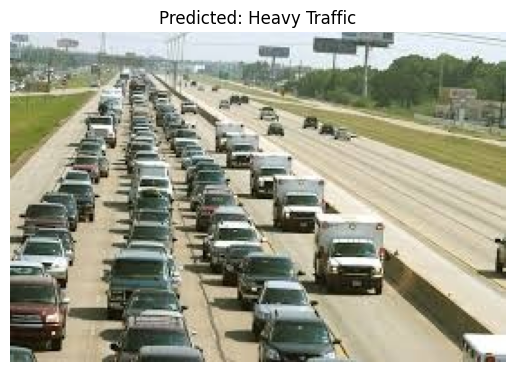

In [14]:
import matplotlib.pyplot as plt

if pred < 0.5:
    prediction_text = "Heavy Traffic"
else:
    prediction_text = "Light Traffic"

plt.imshow(load_img(random_image_path))
plt.title(f"Predicted: {prediction_text}")
plt.axis('off')
plt.show()